##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Overfit and underfit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/overfit_and_underfit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/overfit_and_underfit.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

As always, the code in this example will use the `tf.keras` API, which you can learn more about in the TensorFlow [Keras guide](https://www.tensorflow.org/guide/keras).

In both of the previous examples—[classifying text](https://www.tensorflow.org/tutorials/keras/text_classification_with_hub) and [predicting fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression) — we saw that the accuracy of our model on the validation data would peak after training for a number of epochs, and would then stagnate or start decreasing.

In other words, our model would *overfit* to the training data. Learning how to deal with overfitting is important. Although it's often possible to achieve high accuracy on the *training set*, what we really want is to develop models that generalize well to a *testing set* (or data they haven't seen before).

The opposite of overfitting is *underfitting*. Underfitting occurs when there is still room for improvement on the test data. This can happen for a number of reasons: If the model is not powerful enough, is over-regularized, or has simply not been trained long enough. This means the network has not learned the relevant patterns in the training data.

If you train for too long though, the model will start to overfit and learn patterns from the training data that don't generalize to the test data. We need to strike a balance. Understanding how to train for an appropriate number of epochs as we'll explore below is a useful skill.

To prevent overfitting, the best solution is to use more complete training data. The dataset should cover the full range of inputs that the model is expected to handle. Additional data may only be useful if it covers new and interesting cases.

A model trained on more complete data will naturally generalize better. When that is no longer possible, the next best solution is to use techniques like regularization. These place constraints on the quantity and type of information your model can store.  If a network can only afford to memorize a small number of patterns, the optimization process will force it to focus on the most prominent patterns, which have a better chance of generalizing well.

In this notebook, we'll explore several common regularization techniques, and use them to improve on a classification model.

## Setup

Before getting started, import the necessary packages:

In [3]:
#!python -m pip install tensorflow

In [4]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0


In [177]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [6]:
from  IPython import display
from matplotlib import pyplot as plt

import numpy as np

import pathlib
import shutil
import tempfile


In [7]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset

The goal of this tutorial is not to do particle physics, so don't dwell on the details of the dataset. It contains 11&#x202F;000&#x202F;000 examples, each with 28 features, and a binary class label.

In [7]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 259s 0us/step


In [8]:
FEATURES = 28

The `tf.data.experimental.CsvDataset` class can be used to read csv records directly from a gzip file with no intermediate decompression step.

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

That csv reader class returns a list of scalars for each record. The following function repacks that list of scalars into a (feature_vector, label) pair.

In [10]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

TensorFlow is most efficient when operating on large batches of data.

So instead of repacking each row individually make a new `Dataset` that takes batches of 10000-examples, applies the `pack_row` function to each batch, and then splits the batches back up into individual records:

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

Have a look at some of the records from this new `packed_ds`.

The features are not perfectly normalized, but this is sufficient for this tutorial.

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


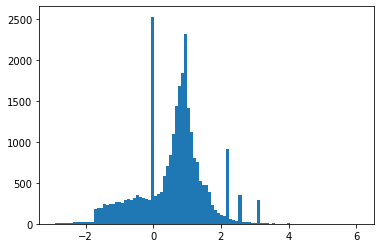

In [12]:
for features,label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins = 101)

To keep this tutorial relatively short use just the first 1000 samples for validation, and the next 10 000 for training:

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

The `Dataset.skip` and `Dataset.take` methods make this easy.

At the same time, use the `Dataset.cache` method to ensure that the loader doesn't need to re-read the data from the file on each epoch:

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

These datasets return individual examples. Use the `.batch` method to create batches of an appropriate size for training. Before batching also remember to `.shuffle` and `.repeat` the training set.

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# FMNS: Try our candles instead

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import time
import h5py
import copy
import datetime
import ta
#import yfinance as yf
import tensorflow as tf
import tensorflow.compat.v2.feature_column as fc
from IPython.display import clear_output
import pyodbc

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, log_loss

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.exceptions import ConvergenceWarning 
from sklearn import ensemble
# ConvergenceWarning('ignore')
# Do you wanna see?
verbose = True

import sys
sys.path.append('../')
#sys.path.append('...../')

from utils.data_extraction import load_data_final,load_data_and_save
from utils.data_cleaning import HFDataCleaning
from utils.generate_features import candleCreateNP_vect_final,\
                                    generateFeatures_final
from utils.preprocessing_features_and_labels import extract_labels,\
                                                    align_features_and_labels,\
                                                    pre_processing_initial,\
                                                    pre_processing_extended,\
                                                    pre_processing
from utils.models import make_input_fn
from utils.models import performanceTesting,scoreFunction

In [9]:
# Do we extract new data or read in?
readIn = True
# run load_data()
if readIn:
    
    # Listing the data files 
    #path = '../../../Google Drev/Thesis/Data/TAQ/AggregatedTAQ'
    path = 'F:/AggregatedTAQ/round3'
    datafiles = os.listdir(path)
    content = np.concatenate([['\n\n'],[str(j)+': '+i+'\n' for j,i in enumerate(datafiles) if 'csv' in i],['\n\n']])
    
    # Asking for user input
    file = input('Which one do you want to load? %s'%''.join(content))
    data = pd.read_csv(path + '/' + datafiles[int(file)],
                       header = None,
                       names=['open','high','low','close','spread_open',
                              'spread_high','spread_low','spread_close',
                              'bidsize_open','bidsize_high','bidsize_low','bidsize_close',
                              'ofrsize_open','ofrsize_high','ofrsize_low','ofrsize_close',
                              'Ticker'])
else:
    
    # print(os.listdir())
    try:
        path = 'a:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
    except:
        path = 't:/taqhdf5'  #'a:/taqhdf5'
        os.listdir(path)
        
    # Sample type
    data_sample = 'full' # or 'stable'
    # allFiles = os.listdir(path)
    # print(len(allFiles), allFiles[:5], allFiles[-5:])
    # print(allFiles[-10:])

    #dates = np.array(['2020040' + str(i) if i < 10 else '202004' + str(i) for i in np.arange(1,16)]).astype(int)
    dates = np.array(['20200501']).astype(int)#,'20200402','20200403','20200406','20200407'

    # Provide a list of tickers of interest
    
    tickers = sorted(['TSLA','FB'])#'MSFT'
    
    # Do we need data on trades, quotes or both?
    dataNeeded = 'quotes' # 'trades', 'quotes' or 'both'
    
    if dataNeeded == 'trades':
        tradeData = load_data_final(dates, tickers, dataNeeded, path, verbose)
    elif dataNeeded == 'quotes':
        quoteData = load_data_final(dates,
                                    tickers,
                                    dataNeeded,
                                    path,
                                    verbose,
                                    extract_candles = False,
                                    aggHorizon = 1,
                                    extra_features_from_quotes = None,
                                    data_sample = data_sample)
    elif dataNeeded == 'both':
        tradeData, quoteData = load_data_final(dates, tickers, dataNeeded, path, verbose)

Which one do you want to load? 

0: aggregateTAQ_10sec.csv
1: aggregateTAQ_30sec.csv
2: aggregateTAQ_60sec.csv


0


In [10]:
data[data.Ticker=='TSLA']

open     high      low    close  spread_open  spread_high  \
20200501 0     755.140  757.625  753.500  757.625         1.72         2.69   
         1     757.820  762.525  757.625  762.525         0.36         2.29   
         2     762.525  762.530  760.400  760.945         0.95         4.42   
         3     760.595  761.095  758.900  759.000         2.63         3.61   
         4     759.000  760.750  759.000  759.230         2.00         3.62   
...                ...      ...      ...      ...          ...          ...   
20200529 2335  833.915  834.145  833.910  834.145         0.11         0.30   
         2336  834.140  834.220  833.945  834.215         0.16         0.31   
         2337  834.215  834.270  833.920  833.985         0.13         0.34   
         2338  834.065  834.320  833.930  834.280         0.19         0.41   
         2339  834.280  834.395  834.115  834.145         0.22         0.47   

               spread_low  spread_close  bidsize_open  bidsize_high  \
20200501 0           0.02          0.75           1.0           7.0   
         1           0.11          0.95           1.0           3.0   
         2           0.58          3.33           1.0           2.0   
         3           1.08          2.00           1.0           3.0   
         4           0.78          2.46           4.0           7.0   
...                   ...           ...           ...           ...   
20200529 2335        0.01          0.15           1.0           3.0   
         2336        0.01          0.13           1.0           3.0   
         2337        0.01          0.03           3.0           4.0   
         2338        0.01          0.22           1.0           4.0   
         2339        0.04          0.17           1.0         120.0   

               bidsize_low  bidsize_close  ofrsize_open  ofrsize_high  \
20200501 0             1.0            2.0           5.0          10.0   
         1             1.0            1.0           4.0          26.0   
         2             1.0            1.0          14.0          14.0   
         3             1.0            3.0           1.0           2.0   
         4             1.0            6.0           1.0           1.0   
...                    ...            ...           ...           ...   
20200529 2335          1.0            1.0           2.0          53.0   
         2336          1.0            3.0           1.0          45.0   
         2337          1.0            1.0          44.0          45.0   
         2338          1.0            1.0           1.0          52.0   
         2339          1.0           90.0          16.0          30.0   

               ofrsize_low  ofrsize_close Ticker  
20200501 0             1.0            4.0   TSLA  
         1             1.0           15.0   TSLA  
         2             1.0            2.0   TSLA  
         3             1.0            1.0   TSLA  
         4             1.0            1.0   TSLA  
...                    ...            ...    ...  
20200529 2335          1.0            1.0   TSLA  
         2336          1.0           43.0   TSLA  
         2337          1.0            1.0   TSLA  
         2338          1.0           15.0   TSLA  
         2339          1.0           28.0   TSLA  

[46800 rows x 17 columns]

In [11]:
candles[['open','high','low','close']].values

NameError: name 'candles' is not defined

NameError: name 'features' is not defined

In [268]:
########### Generate Features ################

ticker_to_model = 'TSLA'
candles = data[data.Ticker==ticker_to_model]

n_feature_lags = 5
features = generateFeatures_final(data = candles, 
                                  listOfFeatures = [
                                                    'pastobs',
                                                    'spread',
                                                    'bidsize',
                                                    'ofrsize',
                                                    'stok',
                                                    'stod',
                                                    'sstod',
                                                    'wilr',
                                                    'roc',
                                                    'rsi',
                                                    'atr',
                                                    'cci',
                                                    'dpo',
                                                    'sma',
                                                    'ema',
                                                    'macd',
                                                    'dis5',
                                                    'dis10',
                                                   ], 
                                   feature_lags = n_feature_lags)

########### Generate Labels ################

n_classes = 2
# extract first 4 columns as the lag0 or raw OHLC prices (used for labelling)
price_candles = candles.iloc[:, :4].values
labels = extract_labels(data = price_candles, classes = n_classes, group_style = 'equal')

########### Align Data ################

# from imported function (see testing_preprocessing_features_and_labels.ipynb for thorough experimenting with all the cut-offs):    
X, y = align_features_and_labels(candles = candles, 
                                 prediction_horizon = 1, 
                                 features = features, 
                                 n_feature_lags = n_feature_lags, 
                                 n_classes = n_classes, # 5,
                                 safe_burn_in = False, 
                                 data_sample = 'full')

['open_lag0' 'open_lag1' 'open_lag2' 'open_lag3' 'open_lag4' 'open_lag5'
 'high_lag0' 'high_lag1' 'high_lag2' 'high_lag3' 'high_lag4' 'high_lag5'
 'low_lag0' 'low_lag1' 'low_lag2' 'low_lag3' 'low_lag4' 'low_lag5'
 'close_lag0' 'close_lag1' 'close_lag2' 'close_lag3' 'close_lag4'
 'close_lag5']


In [269]:
candles.iloc[:, :4] #.values

open     high      low    close
20200501 0     755.140  757.625  753.500  757.625
         1     757.820  762.525  757.625  762.525
         2     762.525  762.530  760.400  760.945
         3     760.595  761.095  758.900  759.000
         4     759.000  760.750  759.000  759.230
...                ...      ...      ...      ...
20200529 2335  833.915  834.145  833.910  834.145
         2336  834.140  834.220  833.945  834.215
         2337  834.215  834.270  833.920  833.985
         2338  834.065  834.320  833.930  834.280
         2339  834.280  834.395  834.115  834.145

[46800 rows x 4 columns]

In [270]:
features

open_lag0  high_lag0  low_lag0  close_lag0  spread_open_lag0  \
20200501 0        -2.705      0.000    -2.705     762.215              1.90   
         1         2.535      3.750    -0.275     759.730              1.47   
         2         3.170      4.155    -1.605     756.670              2.38   
         3        -2.405      0.000    -3.325     759.075              2.52   
         4         1.795      1.795    -0.155     757.280              1.85   
...                  ...        ...       ...         ...               ...   
20200529 2335        NaN        NaN       NaN         NaN               NaN   
         2336        NaN        NaN       NaN         NaN               NaN   
         2337        NaN        NaN       NaN         NaN               NaN   
         2338        NaN        NaN       NaN         NaN               NaN   
         2339        NaN        NaN       NaN         NaN               NaN   

               spread_high_lag0  spread_low_lag0  spread_close_lag0  \
20200501 0                 3.01             0.80               1.37   
         1                 4.25             0.13               2.16   
         2                 5.91             1.41               2.52   
         3                 2.73             0.52               1.85   
         4                 2.73             0.98               1.86   
...                         ...              ...                ...   
20200529 2335               NaN              NaN                NaN   
         2336               NaN              NaN                NaN   
         2337               NaN              NaN                NaN   
         2338               NaN              NaN                NaN   
         2339               NaN              NaN                NaN   

               bidsize_open_lag0  bidsize_high_lag0  ...  atr_lag5   cci_lag5  \
20200501 0                   1.0                3.0  ...  0.000000        NaN   
         1                   1.0                5.0  ...  0.000000        NaN   
         2                   5.0                7.0  ...  0.000000        NaN   
         3                   5.0                5.0  ...  0.000000        NaN   
         4                   3.0                3.0  ...  0.000000        NaN   
...                          ...                ...  ...       ...        ...   
20200529 2335                NaN                NaN  ...  0.440918  39.241955   
         2336                NaN                NaN  ...  0.429067  56.428874   
         2337                NaN                NaN  ...  0.423419  56.444558   
         2338                NaN                NaN  ...  0.421032  82.112931   
         2339                NaN                NaN  ...  0.410958  92.055609   

               dpo_lag5    sma_lag5    ema_lag5  macd_lag5  macd_diff_lag5  \
20200501 0          NaN         NaN         NaN        NaN             NaN   
         1          NaN         NaN         NaN        NaN             NaN   
         2          NaN         NaN         NaN        NaN             NaN   
         3          NaN         NaN         NaN        NaN             NaN   
         4          NaN         NaN         NaN        NaN             NaN   
...                 ...         ...         ...        ...             ...   
20200529 2335   0.03525  833.457083  833.702465   0.257163       -0.038690   
         2336  -0.99975  833.489583  833.781317   0.279000       -0.013482   
         2337  -0.81525  833.592083  833.812653   0.274582       -0.014321   
         2338  -1.09225  833.707500  833.884552   0.291524        0.002097   
         2339  -0.43900  833.835417  833.924621   0.290706        0.001023   

               macd_signal_lag5   dis5_lag5  dis10_lag5  
20200501 0                  NaN         NaN         NaN  
         1                  NaN         NaN         NaN  
         2                  NaN         NaN         NaN  
         3                  NaN         NaN         NaN  
         4   

In [271]:
X

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,atr_lag5,cci_lag5,dpo_lag5,sma_lag5,ema_lag5,macd_lag5,macd_diff_lag5,macd_signal_lag5,dis5_lag5,dis10_lag5
0,1.655,1.655,-0.040,767.760,1.69,2.07,0.44,1.36,1.0,4.0,...,2.277215,49.752409,-2.02475,767.945000,767.336312,2.759330,0.087870,2.671460,99.731883,99.760420
1,-0.970,0.305,-0.970,768.655,1.21,1.43,0.50,0.69,1.0,2.0,...,2.185628,42.465948,-0.42950,768.385417,767.389187,2.582352,-0.071287,2.653639,99.899408,99.814655
2,-0.745,0.050,-1.015,769.250,0.99,1.34,0.35,1.22,1.0,1.0,...,2.196298,59.194726,-0.31675,768.816667,767.737004,2.571416,-0.065778,2.637194,100.145342,100.036848
3,0.280,1.715,-0.375,768.900,1.08,2.10,0.57,0.80,1.0,1.0,...,2.188348,60.916684,1.09200,769.221667,768.078234,2.557875,-0.063455,2.621330,100.158963,100.058349
4,0.195,0.625,-0.130,768.625,0.64,1.69,0.33,1.23,1.0,3.0,...,2.121680,57.573206,2.10050,769.397083,768.242352,2.453501,-0.134263,2.587764,100.059582,99.979527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46756,0.005,0.050,-0.110,833.890,0.19,0.25,0.04,0.16,1.0,9.0,...,0.525469,-64.496530,0.47775,833.610417,833.454734,0.224050,-0.264101,0.488151,100.057503,100.004499
46757,-0.230,0.000,-0.235,834.145,0.11,0.30,0.01,0.15,1.0,3.0,...,0.512221,-58.165298,0.56725,833.527917,833.454006,0.207076,-0.224860,0.431936,100.037809,100.010860
46758,-0.075,0.005,-0.270,834.215,0.16,0.31,0.01,0.13,1.0,3.0,...,0.497420,-55.473789,0.32900,833.438750,833.451851,0.190620,-0.193053,0.383673,100.023523,100.018301
46759,0.230,0.285,-0.065,833.985,0.13,0.34,0.01,0.03,3.0,4.0,...,0.495461,-13.522275,0.27350,833.407500,833.513874,0.208660,-0.140010,0.348671,100.043432,100.062760


In [85]:
'''
We need:

validate_ds = val_data.cache()
train_ds = train_data.cache()

validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.batch(BATCH_SIZE)


'''

'\nWe need:\n\nvalidate_ds = val_data.cache()\ntrain_ds = train_data.cache()\n\nvalidate_ds = validate_ds.batch(BATCH_SIZE)\ntrain_ds = train_ds.batch(BATCH_SIZE)\n\n\n'

In [272]:
val_cutoff = int(X.shape[0]*0.8)
train_ds, train_y = X.iloc[:val_cutoff, :], y[:val_cutoff]
validate_ds, val_y = X.iloc[val_cutoff:, :], y[val_cutoff:]


In [273]:
N_VALIDATION = y[val_cutoff:].shape[0] #int(1e3)
N_TRAIN = y[:val_cutoff].shape[0] #int(1e4)
# BUFFER_SIZE = int(1e4)
BATCH_SIZE = 256 #512 #32
MAX_EPOCHS = 500

STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

N_REPEAT = int(N_TRAIN / ((STEPS_PER_EPOCH * MAX_EPOCHS) / BATCH_SIZE))
FEATURES = features.shape[1]

N_TRAIN, N_VALIDATION, STEPS_PER_EPOCH, N_REPEAT, STEPS_PER_EPOCH * MAX_EPOCHS

(37408, 9353, 146, 131, 73000)

In [274]:
X.iloc[val_cutoff:end_cutoff, :]

,open_lag0,high_lag0,low_lag0,close_lag0,spread_open_lag0,spread_high_lag0,spread_low_lag0,spread_close_lag0,bidsize_open_lag0,bidsize_high_lag0,...,atr_lag5,cci_lag5,dpo_lag5,sma_lag5,ema_lag5,macd_lag5,macd_diff_lag5,macd_signal_lag5,dis5_lag5,dis10_lag5
37408,0.615,0.765,-0.190,829.745,0.66,1.88,0.49,1.49,1.0,19.0,...,1.652706,325.673076,-1.78275,819.335417,821.006514,1.952296,1.417742,0.534554,101.052779,101.389456
37409,0.930,1.165,-0.950,828.770,1.40,2.55,0.48,1.60,19.0,20.0,...,1.571798,216.859739,-2.27175,820.557083,822.590896,2.629213,1.675727,0.953486,100.715533,101.219053
37410,0.115,0.600,-0.535,828.390,1.07,2.60,0.01,1.72,1.0,2.0,...,1.560241,166.433104,-2.89250,821.757500,823.923066,3.125212,1.737380,1.387831,100.359059,101.035822
37411,-0.675,0.460,-1.030,829.010,1.61,2.45,0.62,1.86,1.0,1.0,...,1.565581,124.914063,-3.56400,822.896250,824.946441,3.424353,1.629217,1.795136,99.941280,100.788335
37412,-0.070,0.520,-0.400,829.080,1.86,1.86,0.25,0.78,2.0,4.0,...,1.506254,103.420475,-4.04550,824.017917,825.779296,3.602548,1.445930,2.156618,99.929358,100.600555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46756,0.005,0.050,-0.110,833.890,0.19,0.25,0.04,0.16,1.0,9.0,...,0.525469,-64.496530,0.47775,833.610417,833.454734,0.224050,-0.264101,0.488151,100.057503,100.004499
46757,-0.230,0.000,-0.235,834.145,0.11,0.30,0.01,0.15,1.0,3.0,...,0.512221,-58.165298,0.56725,833.527917,833.454006,0.207076,-0.224860,0.431936,100.037809,100.010860
46758,-0.075,0.005,-0.270,834.215,0.16,0.31,0.01,0.13,1.0,3.0,...,0.497420,-55.473789,0.32900,833.438750,833.451851,0.190620,-0.193053,0.383673,100.023523,100.018301
46759,0.230,0.285,-0.065,833.985,0.13,0.34,0.01,0.03,3.0,4.0,...,0.495461,-13.522275,0.27350,833.407500,833.513874,0.208660,-0.140010,0.348671,100.043432,100.062760


In [275]:
train_ds.shape, train_y.shape, validate_ds.shape, val_y.shape

((37408, 192), (37408,), (9353, 192), (9353,))

In [276]:
train_ds = tf.data.Dataset.from_tensor_slices((X.iloc[:val_cutoff, :].values, y[:val_cutoff])).cache().repeat(N_REPEAT).batch(BATCH_SIZE)
train_ds

<BatchDataset shapes: ((None, 192), (None,)), types: (tf.float64, tf.float64)>

In [277]:
for feat, targ in train_ds.take(2):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[ 1.65500000e+00  1.65500000e+00 -4.00000000e-02 ...  2.67146029e+00
   9.97318829e+01  9.97604205e+01]
 [-9.70000000e-01  3.05000000e-01 -9.70000000e-01 ...  2.65363860e+00
   9.98994083e+01  9.98146548e+01]
 [-7.45000000e-01  5.00000000e-02 -1.01500000e+00 ...  2.63719415e+00
   1.00145342e+02  1.00036848e+02]
 ...
 [-4.60000000e-01  0.00000000e+00 -9.05000000e-01 ...  5.49947794e-01
   9.99404677e+01  9.98417581e+01]
 [ 1.30000000e-01  2.75000000e-01  0.00000000e+00 ...  4.35363449e-01
   9.97900612e+01  9.97044912e+01]
 [-2.00000000e-02  1.75000000e-01 -5.45000000e-01 ...  3.20229782e-01
   9.99221795e+01  9.98335985e+01]], Target: [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0.
 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1

In [278]:
validate_ds = tf.data.Dataset.from_tensor_slices((X.iloc[val_cutoff:end_cutoff, :].values, 
                                                  y[val_cutoff:end_cutoff]))\
                                                    .cache().repeat(N_REPEAT).batch(BATCH_SIZE)

In [279]:
validate_ds

<BatchDataset shapes: ((None, 192), (None,)), types: (tf.float64, tf.float64)>

In [280]:
for feat, targ in validate_ds.take(2):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [[ 6.15000000e-01  7.65000000e-01 -1.90000000e-01 ...  5.34554462e-01
   1.01052779e+02  1.01389456e+02]
 [ 9.30000000e-01  1.16500000e+00 -9.50000000e-01 ...  9.53486257e-01
   1.00715533e+02  1.01219053e+02]
 [ 1.15000000e-01  6.00000000e-01 -5.35000000e-01 ...  1.38783132e+00
   1.00359059e+02  1.01035822e+02]
 ...
 [ 1.35000000e-01  2.00000000e-01 -1.70000000e-01 ... -4.66181892e-01
   9.98247260e+01  9.97631859e+01]
 [-1.75000000e-01  1.10000000e-01 -1.80000000e-01 ... -5.22307076e-01
   9.98658450e+01  9.97716776e+01]
 [ 3.70000000e-01  6.75000000e-01 -1.50000000e-02 ... -5.87850906e-01
   9.98868255e+01  9.97748772e+01]], Target: [0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1

## Demonstrate overfitting

The simplest way to prevent overfitting is to start with a small model: A model with a small number of learnable parameters (which is determined by the number of layers and the number of units per layer). In deep learning, the number of learnable parameters in a model is often referred to as the model's "capacity".

Intuitively, a model with more parameters will have more "memorization capacity" and therefore will be able to easily learn a perfect dictionary-like mapping between training samples and their targets, a mapping without any generalization power, but this would be useless when making predictions on previously unseen data.

Always keep this in mind: deep learning models tend to be good at fitting to the training data, but the real challenge is generalization, not fitting.

On the other hand, if the network has limited memorization resources, it will not be able to learn the mapping as easily. To minimize its loss, it will have to learn compressed representations that have more predictive power. At the same time, if you make your model too small, it will have difficulty fitting to the training data. There is a balance between "too much capacity" and "not enough capacity".

Unfortunately, there is no magical formula to determine the right size or architecture of your model (in terms of the number of layers, or the right size for each layer). You will have to experiment using a series of different architectures.

To find an appropriate model size, it's best to start with relatively few layers and parameters, then begin increasing the size of the layers or adding new layers until you see diminishing returns on the validation loss.

Start with a simple model using only `layers.Dense` as a baseline, then create larger versions, and compare them.

### Training procedure

Many models train better if you gradually reduce the learning rate during training. Use `optimizers.schedules` to reduce the learning rate over time:

In [281]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

The code above sets a `schedules.InverseTimeDecay` to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

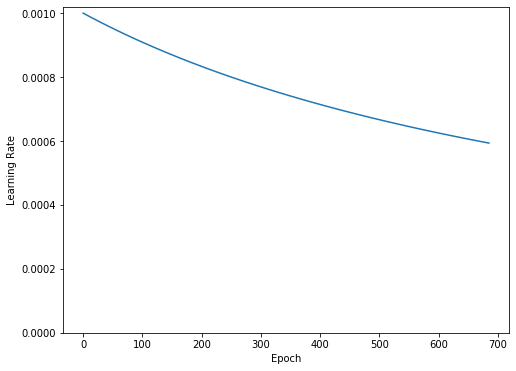

In [282]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


Each model in this tutorial will use the same training configuration. So set these up in a reusable way, starting with the list of callbacks.

The training for this tutorial runs for many short epochs. To reduce the logging noise use the `tfdocs.EpochDots` which simply prints a `.` for each epoch, and a full set of metrics every 100 epochs.

Next include `callbacks.EarlyStopping` to avoid long and unnecessary training times. Note that this callback is set to monitor the `val_binary_crossentropy`, not the `val_loss`. This difference will be important later.

Use `callbacks.TensorBoard` to generate TensorBoard logs for the training.


In [283]:
def get_callbacks(name):
    return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
    ]

Similarly each model will use the same `Model.compile` and `Model.fit` settings:

In [284]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000, verbose=0):
    if optimizer is None:
    optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

    model.summary()

    history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=verbose)
    return history

### Tiny model

Start by training a model:

In [285]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [286]:
size_histories = {}

In [287]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 17        
Total params: 3,105
Trainable params: 3,105
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4955,  binary_crossentropy:2.9205,  loss:2.9205,  val_accuracy:0.4975,  val_binary_crossentropy:1.3349,  val_loss:1.3349,  
....................................................................................................
Epoch: 100, accuracy:0.4933,  binary_crossentropy:0.8448,  loss:0.8448,  val_accuracy:0.4714,  val_binary_crossentropy:0.8758,  val_loss:0.8758,  
.

In [207]:
size_histories['Tiny'].history['binary_crossentropy']

[2.3771820068359375,
 0.8997141718864441,
 0.8829426169395447,
 0.8948631882667542,
 0.9026139974594116,
 0.8684822916984558,
 0.8804076313972473,
 0.8592902421951294,
 0.8631515502929688,
 0.8395841717720032]

Now check how the model did:

(0.5, 1)

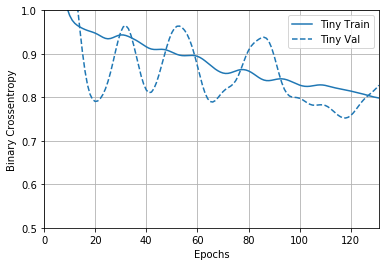

In [288]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 1])

### Small model

To see if you can beat the performance of the small model, progressively train some larger models.

Try two hidden layers with 16 units each:

In [289]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])

In [290]:
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small', max_epochs=MAX_EPOCHS, verbose=0)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 16)                3088      
_________________________________________________________________
dense_43 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 17        
Total params: 3,377
Trainable params: 3,377
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5017,  binary_crossentropy:3.0077,  loss:3.0077,  val_accuracy:0.4903,  val_binary_crossentropy:1.2180,  val_loss:1.2180,  
....................................................................................................
Epoch: 100, accuracy:0.4952,  binary_crossentropy:0.7250,  loss:0.7250,  val_accuracy:0.4727,  val_binary_crossentropy:0.7768,  val_lo

### Medium model

Now try 3 hidden layers with 64 units each:

In [291]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

And train the model using the same data:

In [292]:
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_46 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_47 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 65        
Total params: 20,737
Trainable params: 20,737
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4975,  binary_crossentropy:3.1182,  loss:3.1182,  val_accuracy:0.4716,  val_binary_crossentropy:6.2460,  val_loss:6.2459,  
....................................................................................................


### Large model

As an exercise, you can create an even larger model, and see how quickly it begins overfitting.  Next, let's add to this benchmark a network that has much more capacity, far more than the problem would warrant:

In [293]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

And, again, train the model using the same data:

In [294]:
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_50 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_51 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_52 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4933,  binary_crossentropy:5.5722,  loss:5.5722,  val_accuracy:0.4716,  val_binary_crossent

### Plot the training and validation losses

The solid lines show the training loss, and the dashed lines show the validation loss (remember: a lower validation loss indicates a better model).

While building a larger model gives it more power, if this power is not constrained somehow it can easily overfit to the training set.

In this example, typically, only the `"Tiny"` model manages to avoid overfitting altogether, and each of the larger models overfit the data more quickly. This becomes so severe for the `"large"` model that you need to switch the plot to a log-scale to really see what's happening.

This is apparent if you plot and compare the validation metrics to the training metrics.

* It's normal for there to be a small difference.
* If both metrics are moving in the same direction, everything is fine.
* If the validation metric begins to stagnate while the training metric continues to improve, you are probably close to overfitting.
* If the validation metric is going in the wrong direction, the model is clearly overfitting.

Text(0.5, 0, 'Epochs [Log Scale]')

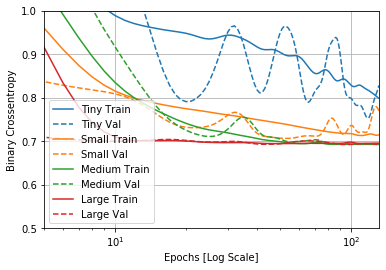

In [295]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

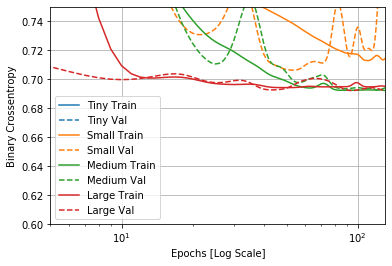

In [301]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 0.75])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

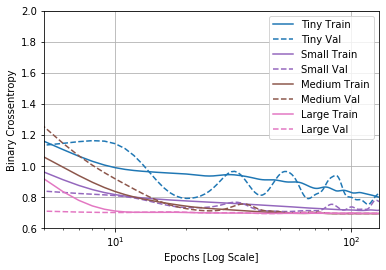

In [328]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.6, 2])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

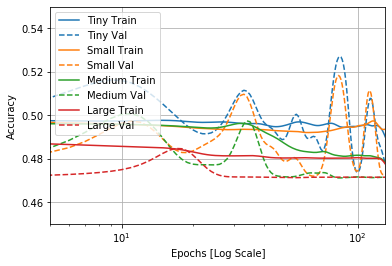

In [305]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.45, 0.55])
plt.xlabel("Epochs [Log Scale]")

Note: All the above training runs used the `callbacks.EarlyStopping` to end the training once it was clear the model was not making progress.

### View in TensorBoard

These models all wrote TensorBoard logs during training.

Open an embedded  TensorBoard viewer inside a notebook:

In [ ]:
#docs_infra: no_execute

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Open an embedded TensorBoard viewer
%tensorboard --logdir {logdir}/sizes

You can view the [results of a previous run](https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorBoard.dev](https://tensorboard.dev/).

TensorBoard.dev is a managed experience for hosting, tracking, and sharing ML experiments with everyone.

It's also included in an `<iframe>` for convenience:

In [32]:
display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px")

If you want to share TensorBoard results you can upload the logs to [TensorBoard.dev](https://tensorboard.dev/) by copying the following into a code-cell.

Note: This step requires a Google account.

```
!tensorboard dev upload --logdir  {logdir}/sizes
```

Caution: This command does not terminate. It's designed to continuously upload the results of long-running experiments. Once your data is uploaded you need to stop it using the "interrupt execution" option in your notebook tool.

## Strategies to prevent overfitting

Before getting into the content of this section copy the training logs from the `"Tiny"` model above, to use as a baseline for comparison.

In [306]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

WindowsPath('C:/Users/fstri/AppData/Local/Temp/tmpcqha_tac/tensorboard_logs/regularizers/Tiny')

In [307]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

### Add weight regularization


You may be familiar with Occam's Razor principle: given two explanations for something, the explanation most likely to be correct is the "simplest" one, the one that makes the least amount of assumptions. This also applies to the models learned by neural networks: given some training data and a network architecture, there are multiple sets of weights values (multiple models) that could explain the data, and simpler models are less likely to overfit than complex ones.

A "simple model" in this context is a model where the distribution of parameter values has less entropy (or a model with fewer parameters altogether, as we saw in the section above). Thus a common way to mitigate overfitting is to put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular". This is called "weight regularization", and it is done by adding to the loss function of the network a cost associated with having large weights. This cost comes in two flavors:

* [L1 regularization](https://developers.google.com/machine-learning/glossary/#L1_regularization), where the cost added is proportional to the absolute value of the weights coefficients (i.e. to what is called the "L1 norm" of the weights).

* [L2 regularization](https://developers.google.com/machine-learning/glossary/#L2_regularization), where the cost added is proportional to the square of the value of the weights coefficients (i.e. to what is called the squared "L2 norm" of the weights). L2 regularization is also called weight decay in the context of neural networks. Don't let the different name confuse you: weight decay is mathematically the exact same as L2 regularization.

L1 regularization pushes weights towards exactly zero encouraging a sparse model. L2 regularization will penalize the weights parameters without making them sparse since the penalty goes to zero for small weights. one reason why L2 is more common.

In `tf.keras`, weight regularization is added by passing weight regularizer instances to layers as keyword arguments. Let's add L2 weight regularization now.

In [309]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_59 (Dense)             (None, 512)               98816     
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 513       
Total params: 887,297
Trainable params: 887,297
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4972,  binary_crossentropy:5.1431,  loss:6.4530,  val_accuracy:0.5274,  val_binary_crossent

`l2(0.001)` means that every coefficient in the weight matrix of the layer will add `0.001 * weight_coefficient_value**2` to the total **loss** of the network.

That is why we're monitoring the `binary_crossentropy` directly. Because it doesn't have this regularization component mixed in.

So, that same `"Large"` model with an `L2` regularization penalty performs much better:


(0.45, 0.55)

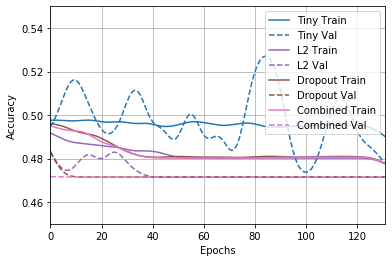

In [320]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

As you can see, the `"L2"` regularized model is now much more competitive with the the `"Tiny"` model. This `"L2"` model is also much more resistant to overfitting than the `"Large"` model it was based on despite having the same number of parameters.

#### More info

There are two important things to note about this sort of regularization.

**First:** if you are writing your own training loop, then you need to be sure to ask the model for its regularization losses.

In [311]:
result = l2_model(features)
regularization_loss=tf.add_n(l2_model.losses)

**Second:** This implementation works by adding the weight penalties to the model's loss, and then applying a standard optimization procedure after that.

There is a second approach that instead only runs the optimizer on the raw loss, and then while applying the calculated step the optimizer also applies some weight decay. This "Decoupled Weight Decay" is seen in optimizers like `optimizers.FTRL` and `optimizers.AdamW`.

### Add dropout

Dropout is one of the most effective and most commonly used regularization techniques for neural networks, developed by Hinton and his students at the University of Toronto.

The intuitive explanation for dropout is that because individual nodes in the network cannot rely on the output of the others, each node must output features that are useful on their own.

Dropout, applied to a layer, consists of randomly "dropping out" (i.e. set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5,
1.3, 0, 1.1].

The "dropout rate" is the fraction of the features that are being zeroed-out; it is usually set between 0.2 and 0.5. At test time, no units are dropped out, and instead the layer's output values are scaled down by a factor equal to the dropout rate, so as to balance for the fact that more units are active than at training time.

In `tf.keras` you can introduce dropout in a network via the Dropout layer, which gets applied to the output of layer right before.

Let's add two Dropout layers in our network to see how well they do at reducing overfitting:

In [312]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 512)             

(0.45, 0.55)

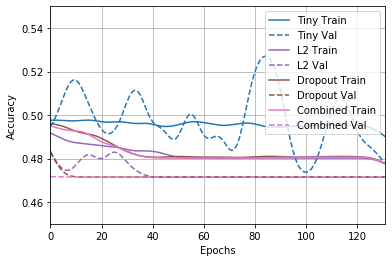

In [319]:
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

It's clear from this plot that both of these regularization approaches improve the behavior of the `"Large"` model. But this still doesn't beat even the `"Tiny"` baseline.

Next try them both, together, and see if that does better.

### Combined L2 + dropout

In [314]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 512)               98816     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_71 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_72 (Dense)             (None, 512)             

(0.45, 0.55)

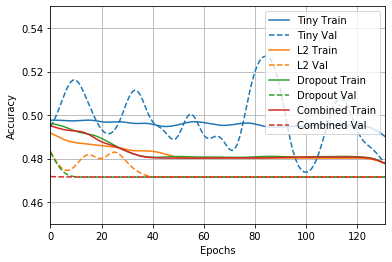

In [324]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.45, 0.55])

(0.6, 3)

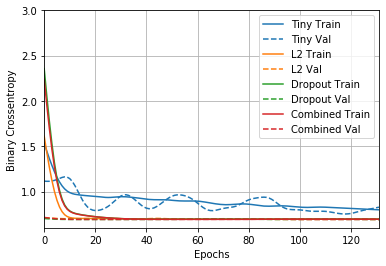

In [325]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 3])

(0.6, 0.95)

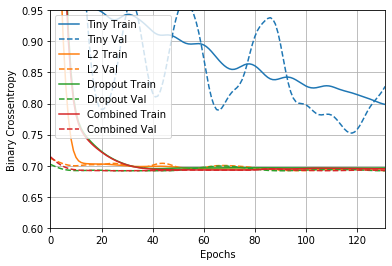

In [326]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(regularizer_histories)
plt.ylim([0.6, 0.95])

This model with the `"Combined"` regularization is obviously the best one so far.

### View in TensorBoard

These models also recorded TensorBoard logs.

To open an embedded  tensorboard viewer inside a notebook, copy the following into a code-cell:

```
%tensorboard --logdir {logdir}/regularizers
```

You can view the [results of a previous run](https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97) of this notebook on [TensorDoard.dev](https://tensorboard.dev/).

It's also included in an `<iframe>` for convenience:

In [42]:
display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")


This was uploaded with:

```
!tensorboard dev upload --logdir  {logdir}/regularizers
```

## Conclusions

To recap: here are the most common ways to prevent overfitting in neural networks:

* Get more training data.
* Reduce the capacity of the network.
* Add weight regularization.
* Add dropout.

Two important approaches not covered in this guide are:

* data-augmentation
* batch normalization

Remember that each method can help on its own, but often combining them can be even more effective.